<a href="https://colab.research.google.com/github/bobby-mclaughlinjr/covid/blob/master/Rt*.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [70]:
import pandas as pd
import numpy as np
import datetime
from ipywidgets import interact, interactive, IntSlider, FloatSlider, fixed, HBox, VBox, Label, Output, Button, Dropdown
import matplotlib.pyplot as plt
from matplotlib import dates as mdates
from matplotlib.patches import Patch
!pip install lmfit
from lmfit import Model

In [0]:
# Data sources
SOURCES = ['CSSE', 'NYT']

CSSE_URL = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
CSSE_COLUMNS = {'Province/State': 'area', 'Country/Region': 'region', 'Lat': 'latitude', 'Long': 'longitude'}

NYT_URL = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv'

FILTERED_REGIONS = ['US', 'Spain', 'Italy', 'France', 'Germany', 'United Kingdom', 'Sweden', 'South Korea', 'Japan', 'Singapore'
                   , 'Denmark', 'Australia', 'California - US', 'Florida - US', 'Georgia - US', 'Illinois - US', 'Louisiana - US'
                   , 'Massachusetts - US', 'Michigan - US', 'New York - US', 'New Jersey - US', 'Pennsylvania - US', 'Texas - US']

In [0]:
# Default parameters
ASYMPTOMATIC = 0.75
R0 = 2.2
INCUBATION_DURATION = 5.2
INFECTION_DURATION = 2.9

In [0]:
class Rt(object):

    def __init__(self
                 , R0=R0
                 , incubation_duration=INCUBATION_DURATION
                 , infection_duration=INFECTION_DURATION
                 , asymptomatic=ASYMPTOMATIC
                 , data=None
                 ):

        self.R0 = R0
        self.incubation_duration = incubation_duration
        self.infection_duration = infection_duration
        self.asymptomatic = asymptomatic

        self.data = data
        self.transformed_data = None
        self.projections = None

        self.incubation_duration_slider = interactive(self.set_and_get_solution
                                                      , value=FloatSlider(min=0.1
                                                                          , max=10
                                                                          , step=0.1
                                                                          , value=INCUBATION_DURATION
                                                                          , continuous_update=False
                                                                          , description='Incubation Duration (Tinc)'
                                                                          , style={'description_width': 'initial'}
                                                                          )
                                                      , name=fixed('incubation_duration')
                                                      )

        self.infection_duration_slider = interactive(self.set_and_get_solution
                                                     , value=FloatSlider(min=0.1
                                                                         , max=10
                                                                         , step=0.1
                                                                         , value=INFECTION_DURATION
                                                                         , continuous_update=False
                                                                         , description='Infection Duration (Tinf)'
                                                                         , style={'description_width': 'initial'}
                                                                         )
                                                     , name=fixed('infection_duration')
                                                     )

        # self.reset_button = Button(description='Reset')
        # self.reset_button.on_click(self.reset)

        self.output = Output()
        self.interact = VBox([self.incubation_duration_slider, self.infection_duration_slider, self.output])

    @staticmethod
    def smoothing(X, window=7, resize=False):
        if resize:
            return X.rolling(window=window).mean()[window:]
        else:
            return X.rolling(window=window).mean()

    def set_property(self, name, value=None):
        setattr(self, name, value)

    def set_and_get_solution(self, name=None, value=None):
        if name is not None:
            self.set_property(name=name, value=value)

        self.output.clear_output(wait=True)
        with self.output as f:
            display(self.re_calculate())
            self.plot()

    def reset(self, _):
        self.incubation_duration = INCUBATION_DURATION
        self.infection_duration = INFECTION_DURATION

        self.set_and_get_solution()

    def get_data(self, region=None):
        if region is None: region = FILTERED_REGIONS
        if not isinstance(region, list): region = [region]

        self.data = pd.concat([self.get_CSSE(), self.get_NYT()]).loc[region, :]
        return self

    @staticmethod
    def get_CSSE():
        df = pd.read_csv(CSSE_URL).rename(columns=CSSE_COLUMNS)
        data = pd.melt(df, id_vars=CSSE_COLUMNS.values(), var_name='date', value_name='cases')
        data['date'] = [datetime.datetime.strptime(str(date), '%m/%d/%y') for date in data['date']]

        return data.sort_index().groupby(['region', 'date'])['cases'].sum()

    @staticmethod
    def get_NYT():
        data = pd.read_csv(NYT_URL).rename(columns={'state': 'region'})
        data['region'] = [region + ' - US' for region in data['region']]
        data['date'] = [datetime.datetime.strptime(str(date), '%Y-%m-%d') for date in data['date']]

        return data.groupby(['region', 'date'])['cases'].sum()

    def assumed(self, infectious, Rt, shift=7):
        return (Rt / self.infection_duration) * infectious.shift(shift) * (1 - self.asymptomatic)

    def re_calculate(self, smoothing=7):
        return self.calculate().project(Rt=[None, 0.5, 0.7, 0.9]).get_historical()

    def calculate(self, smoothing=7):
        if self.data is None:
            self.get_data()

        self.transformed_data = self.data.copy(deep=True).groupby(level=0).apply(self._calculate, smoothing=smoothing)
        return self

    def _calculate(self, data, smoothing=7):
        data = data.to_frame('cases').reset_index(level=0, drop=True)

        data['total_cases'] = data['cases'] / (1 - self.asymptomatic)
        data['asymptomatic_cases'] = data['total_cases'] - data['cases']

        data['new_cases'] = data['cases'].diff()
        data['new_total_cases'] = data['total_cases'].diff()
        data['new_total_cases_shift'] = data['new_total_cases'].shift(13)

        # Rt
        data['infectious'] = (data['new_total_cases'] - data['new_total_cases'].shift(3)).expanding().apply(lambda x: np.nansum(x))

        data['Rt^'] = self.smoothing(data['new_total_cases'].rolling(window=3).mean() * self.infection_duration / data['infectious'].rolling(window=3).mean().shift(8), window=smoothing)
        data['Rt*'] = self.smoothing(-(data['total_cases'] - data['new_total_cases_shift']) / ((data['total_cases'] - data['new_total_cases_shift']).shift(1)) * np.log(1 / self.incubation_duration) - 1, window=smoothing)
        data['Rt'] = data[['Rt^', 'Rt*']].mean(axis=1)

        data['ex_ante'] = ((data['Rt'] / self.infection_duration) * data['infectious'].shift(6) * (1 - self.asymptomatic)).shift()
        data['ex_post'] = data['new_cases'].shift(-1)

        return data

    def fit(self, X, incubation_duration, infection_duration, asymptomatic):
        self.incubation_duration = incubation_duration
        self.infection_duration = infection_duration
        self.asymptomatic = asymptomatic

        return self.smoothing(self.calculate().transformed_data['ex_ante'], window=3, resize=True)[22:-1].values

    def project(self, Rt=None, days=100):
        if self.transformed_data is None:
            self.calculate()

        self.projections = self.transformed_data.copy(deep=True).groupby(level=0).apply(self._project, Rt=Rt, days=days)
        return self

    def _project(self, data, Rt=None, days=100):
        data.reset_index(level=0, drop=True, inplace=True)
        if not isinstance(Rt, list): Rt = [Rt]

        results = {}
        for Rt_ in Rt:
            current = Rt_ is None
            if current: Rt_ = data['Rt'][-1]

            infectious_reference = data['infectious'][-7:].tolist()
            new_cases = data['new_cases'][-3:].tolist()

            for x in range(days):
                new = Rt_ / self.infection_duration * infectious_reference[x] * (1 - self.asymptomatic)
                new_cases.append(new)
                infectious_reference.append(
                    infectious_reference[-1] + ((new - new_cases[-4]) * (1 / (1 - self.asymptomatic))))

            new_cases = new_cases[2:]
            if current:
                results['Current'] = new_cases
            else:
                results[Rt_] = new_cases

        results = pd.DataFrame.from_dict(results)
        results.index = [data.index[-1] + datetime.timedelta(days=day) for day in range(days + 1)]
        return results

    def get_historical(self, date=None):
        if self.data is None:
            self.get_data().calculate()

        results = self.transformed_data.copy(deep=True).groupby(level=0).apply(self._get_historical, date=date)
        return pd.DataFrame(results.tolist(), index=results.index).sort_values('Rt', ascending=False)

    @staticmethod
    def _get_historical(data, date=None):
        data.reset_index(level=0, drop=True, inplace=True)

        if date is None:
            current = data.iloc[-1]
            last = data.iloc[-2]
        else:
            loc = data.index.get_loc(date)
            current = data.iloc[loc]
            last = data.iloc[loc - 1]

        return {'Rt': round(current['Rt'], 2)
                , 'Last Rt': round(last['Rt'], 2)
                , 'Delta': round(current['Rt'] - last['Rt'], 3)
                , 'Projected': int(current['ex_ante'])
                , 'Last Projected': int(last['ex_ante'])
                , 'Ex Post': int(last['ex_post'])
                , 'Error': int(last['ex_post'] - last['ex_ante'])
                , 'Error %': round((last['ex_ante'] - last['ex_post']) / last['ex_post'] * 100, 1)
                }

    def plot(self):
        data = self.transformed_data.copy(deep=True).reset_index(level=0)[['region', 'ex_ante', 'ex_post']].loc['2020-03-01':]

        projections = self.projections.copy(deep=True).reset_index(level=0)

        dropdown_widget = Dropdown(options=list(set(data['region']))
                                   , value='US'
                                   , disabled=False
                                   , description='Region:'
                                   )

        def plot_it(region):
            region_data = data[data['region'] == region].drop('region', axis=1).rename(columns={'ex_ante': 'Ex Ante', 'ex_post': 'Ex Post'})

            fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 7))

            bottom_ax = axes.flat[1]
            bottom_ax.plot(region_data.index, region_data['Ex Ante'], color='b')
            bottom_ax.plot(region_data.index, region_data['Ex Post'], color='darkorange')
            bottom_ax.set_ylabel('New Cases')
            bottom_ax.set_xlabel('')
            bottom_ax.set_title('Accuracy')
            bottom_ax.grid(which='major', axis='x', c='k', alpha=0.1, zorder=-2)

            bottom_ax2 = bottom_ax.twinx()
            bottom_ax2.set_ylim(-2, 2)
            bottom_ax2.bar(region_data.index, ((region_data['Ex Ante'] - region_data['Ex Post']) / region_data['Ex Post']), color='r', alpha=0.1)
            bottom_ax2.set_ylabel('Error %')
            bottom_ax2.set_yticklabels(['{:,.0%}'.format(y) for y in bottom_ax2.get_yticks()])

            bottom_ax2.xaxis.set_major_locator(mdates.MonthLocator())
            bottom_ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
            bottom_ax2.xaxis.set_minor_locator(mdates.DayLocator())

            bottom_ax2.grid(which='major', axis='y', c='k', alpha=0.1, zorder=-2)
            bottom_ax2.axhline(0, linestyle=':', color='r', lw=1)

            leg = bottom_ax.legend(handles=[
                                            Patch(label='Ex Ante', color='b'),
                                            Patch(label='Ex Post', color='darkorange'),
                                            ]
                                  , loc='lower right'
                                  , columnspacing=.75
                                  , handletextpad=.5
                                  , handlelength=1
                                  )

            leg._legend_box.align = "left"

            top_ax = axes.flat[0]
            region_projections = projections[projections['region'] == region].drop('region', axis=1)
            region_projections.plot(ax=top_ax)
            top_ax.grid(which='major', axis='y', c='k', alpha=0.1, zorder=-2)
            top_ax.set_ylabel('New Cases')
            top_ax.set_title('Projections based on Current / Assumed Rt')
            top_ax.grid(which='major', axis='x', c='k', alpha=0.1, zorder=-2)

            fig.tight_layout()

        display(interactive(plot_it, region=dropdown_widget))

In [74]:
obj = Rt()
obj.interact

{'asymptomatic': 0.6799674232091816,
 'incubation_duration': 4.83842472268503,
 'infection_duration': 3.4883851449186767}

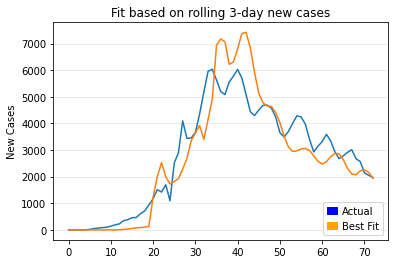

In [76]:
# Fit curve
REGION = 'Italy'
obj = Rt().get_data(region=REGION)

ex_post = obj.smoothing(obj.data.reset_index(level=0, drop=True).diff(), window=3, resize=True).shift(-1)[22:-1].values
temp = np.linspace(0, len(ex_post) - 1, len(ex_post), dtype=int)

model = Model(obj.fit)

param_dict = {
                 'incubation_duration': (5.2, 2, 10)  # format (initial, min, max)
                , 'infection_duration': (2.9, 1, 7)
                , 'asymptomatic': (0.75, 0.25, 0.8)
            }

for key, (init, min, max) in param_dict.items():
    model.set_param_hint(key, value=init, min=min, max=max, vary=True)

params = model.make_params()
result = model.fit(ex_post, params, method='least_squares', X=temp)

best_values = result.best_values
result.plot_fit(datafmt="-")
plt.ylabel('New Cases')
plt.xlabel('')
plt.title('Fit based on rolling 3-day new cases')
plt.grid(which='major', axis='y', c='k', alpha=0.1, zorder=-2)
leg = plt.legend(handles=[
                          Patch(label='Actual', color='b'),
                          Patch(label='Best Fit', color='orange'),
                          ]
                      , loc='lower right'
                      , columnspacing=.75
                      , handletextpad=.5
                      , handlelength=1
                      )
display(best_values)